In [75]:
from pytfa.io.json import load_json_model
from cobra import Reaction

redgem_file_name = 'reduced_model_ETC_core_20240816-155234.json'
reduced_model = load_json_model(redgem_file_name)
reduced_model.optimize()

# remove sinks if there are still any
reduced_model.remove_reactions([rxn.id for rxn in reduced_model.reactions if 'sink' in rxn.id])

# Thermo for sodium
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_std'] = 1.0
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_err'] = 0.1
reduced_model.thermo_data['metabolites']['cpd00971']['error']  = 'Nil'


2024-09-06 15:56:40,392 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [76]:
# Set h_c to h_i 
h_i = reduced_model.metabolites.h_i
h_c = reduced_model.metabolites.h_c
for r in reduced_model.reactions:
    if h_i in r.metabolites:
        stoich = r.metabolites[h_i]
        r.add_metabolites({h_i: -stoich, h_c: stoich})

reduced_model.prepare()
reduced_model.convert()


2024-09-06 15:56:40,965 - thermomodel_Recon3thermoCurated - INFO - # Model preparation starting...
2024-09-06 15:56:41,011 - thermomodel_Recon3thermoCurated - INFO - # Model preparation done.
2024-09-06 15:56:41,012 - thermomodel_Recon3thermoCurated - INFO - # Model conversion starting...
2024-09-06 15:56:41,902 - thermomodel_Recon3thermoCurated - INFO - # Model conversion done.
2024-09-06 15:56:41,904 - thermomodel_Recon3thermoCurated - INFO - # Updating cobra_model variables...
2024-09-06 15:56:41,908 - thermomodel_Recon3thermoCurated - INFO - # cobra_model variables are up-to-date


In [77]:
[ (r.id, r.reaction )for r in reduced_model.metabolites.amp_c.reactions]

[('FACOAL160i', 'atp_c + coa_c + hdca_c --> amp_c + h_c + pmtcoa_c + ppi_c'),
 ('ADK1', 'amp_c + atp_c + h_c --> 2.0 adp_c')]

In [78]:
reduced_model.reactions.ADK1.thermo

{'isTrans': False,
 'computed': True,
 'deltaGR': 10.24962080568946,
 'deltaGRerr': 2}

In [79]:
# Refine Glycolysis corrected delta G constraints from Lehninger:
# Units are in kJ/mol
glycolysis_thermodynamics = {
    'HEX1': -16.7,
    'PGI': 1.7,
    'PFK': -14.9,
    'FBA': 23.8,
    'TPI': 5.6, # Equilibrator value
    'GAPD': 6.3,
    'PGK': -18.8,
    'PGM': 4.4, 
    'ENO': 7.5,
    'PYK': -31.4,
    'LDH_L': 25.1,
    'LDH_Lm': 33.1,
    }

# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in glycolysis_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.5
        dgo.lb = dg * scaling - 0.5
    except ValueError:
        dgo.lb = dg * scaling - 0.5
        dgo.ub = dg * scaling + 0.5

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")


sol = reduced_model.optimize()

HEX1 : -4.491400199999999 < -4.491400199999999 < -3.4914001999999997 kcal/mol
PGI : -0.09368979999999999 < 0.9063102000000001 < 0.9063102000000001 kcal/mol
PFK : -4.0611894 < -4.0611894 < -3.0611894 kcal/mol
FBA : 5.1883428 < 5.1883428 < 6.1883428 kcal/mol
TPI : 0.8384335999999999 < 1.292545 < 1.8384336 kcal/mol
GAPD : 1.0057378 < 1.0057378 < 2.0057378 kcal/mol
PGK : -4.9933128 < -3.9933128 < -3.9933128 kcal/mol
PGM : 0.5516264 < 1.5516264 < 1.5516264 kcal/mol
ENO : 1.292545 < 1.292545 < 2.292545 kcal/mol
PYK : -8.004788399999999 < -8.004788399999999 < -7.0047884 kcal/mol
LDH_L : 5.4990506 < 6.4990506 < 6.4990506 kcal/mol
LDH_Lm : 7.4110986 < 7.4110986 < 8.411098599999999 kcal/mol


In [80]:
# Refine TCA corrected delta G constraints from Lehninger:
# Units are in kJ/mol
tca_thermodynamics = {
    'PDHm' : -33.4,
    'CSm' : -32.3,
    'ACONTm' : 13.3,
    'ICDHxm' : 10.0, # Equilibrator value ?!?!
    'AKGDm' : -33.5,
    'SUCOAS1m' : 2.9,
    #'r0509' : 0, 
    'FUMm': -3.8,
    'MDHm' : 29.7,
    'MDH': 29.7 + 2.3 * 2 * 310 * 2.26 * 0.6 /1000 , # MDH delta proton correction in cytosol
    'ADK1': 0.3, # Equilibrator value ?!
    'FADH2ETC': -70/2, # Equilibrator  value ?
    'G3PD1': -22.6, # Equilibrator value ?!?
    'r0205': -59.7, # Equilibrator value ?!?
}

# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in tca_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.5
        dgo.lb = dg * scaling - 0.5
    except ValueError:
        dgo.lb = dg * scaling - 0.5
        dgo.ub = dg * scaling + 0.5

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")
    

sol = reduced_model.optimize()

PDHm : -8.482800399999999 < -8.482800399999999 < -7.4828003999999995 kcal/mol
CSm : -8.2198938 < -7.2198937999999995 < -7.2198937999999995 kcal/mol
ACONTm : 2.6787798 < 2.6787798 < 3.6787798 kcal/mol
ICDHxm : 1.89006 < 1.89006 < 2.89006 kcal/mol
AKGDm : -8.506701 < -8.506701 < -7.506701 kcal/mol
SUCOAS1m : 0.1931174 < 0.1931174 < 1.1931174 kcal/mol
FUMm : -1.4082227999999999 < -1.4082227999999999 < -0.4082228 kcal/mol
MDHm : 6.5984782 < 6.5984782 < 7.5984782 kcal/mol
MDH : 7.060633585935999 < 7.060633585935999 < 8.060633585936 kcal/mol
ADK1 : -0.4282982 < -0.4282982 < 0.5717018 kcal/mol
FADH2ETC : -8.86521 < -8.86521 < -7.865209999999999 kcal/mol
G3PD1 : -5.9015356 < -5.9015356 < -4.9015356 kcal/mol
r0205 : -14.7686582 < -14.116504745747534 < -13.7686582 kcal/mol


In [81]:
# Make sure that transporters dont have unrealistic equilibrium constants

EPSILON_DG = 1e-2

exceptions = ['ATPS4mi','CYOR_u10mi','CYOOm2i','NADH2_u10mi']
# Print transport deltaG0
for r in reduced_model.reactions:
    if r.thermo['isTrans']:
        try:
            #print(f"{r.id} : {r.reaction} {reduced_model.delta_gstd.get_by_id(r.id)} kcal/mol")
            dgo = reduced_model.delta_gstd.get_by_id(r.id)
            dgo.ub = r.thermo['dgo'] + EPSILON_DG
            dgo.lb = r.thermo['dgo'] - EPSILON_DG

        except KeyError:
            pass

reduced_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-1.000000,None
ACONTm,12.861111,None
AKGDm,12.861111,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
CYOR_u10mi,72.166667,None
NADH2_u10mi,52.305556,None
CYOOm2i,36.083333,None
cyt_atp2adp,172.416667,None


In [82]:
import numpy as np
from pytfa.optim.constraints import ModelConstraint

# Force ATP/ADP ratio to be 10
# Cytosolic ATP/ADP ratio
# https://pubmed.ncbi.nlm.nih.gov/749453/



expression = reduced_model.log_concentration.atp_c.variable - reduced_model.log_concentration.adp_c.variable
id_='atp_c_adp_c_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(10), 
                        ub=np.log(100),
                        )
print(f"Integrate cytosolic ATP/ADP ratio: 10-50 ")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# Force ATP/ADP ratio to bearround 2 and 8
# Cytosolic ATP/ADP ratio
# https://www.mdpi.com/1422-0067/23/10/5550


expression = reduced_model.log_concentration.atp_m.variable - reduced_model.log_concentration.adp_m.variable
id_='atp_m_adp_m_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(2), 
                        ub=np.log(8),
                        )
print(f"Integrate mitochondrial ATP/ADP ratio: 2-8")
sol = reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

# mitochondrial GTP/GDP ratio
expression = reduced_model.log_concentration.gtp_m.variable - reduced_model.log_concentration.gdp_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='gtp_m_gdp_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(300),
                        )
print(f"Integrate mitochondrial GTP/GDP ratio: 10-300")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")        

# mitochondrial NAD/NADH ratio
expression = reduced_model.log_concentration.nad_m.variable - reduced_model.log_concentration.nadh_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_m_nadh_m_ratio', 
                        lb=np.log(6), 
                        ub=np.log(8),
                        )
print(f"Integrate mitochondrial NAD+/NADH ratio: 6-8")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

# Cytoplasmic NAD/NADH ratio
expression = reduced_model.log_concentration.nad_c.variable - reduced_model.log_concentration.nadh_c.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_c_nadh_c_ratio', 
                        lb=np.log(60), 
                        ub=np.log(700),
                        )

print(f"Integrate cytoplasmic NAD+/NADH ratio: 60-700")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

Integrate cytosolic ATP/ADP ratio: 10-50 
ATP yield: 172.41666666666657
Integrate mitochondrial ATP/ADP ratio: 2-8
ATP yield: 172.41666666666657
Integrate mitochondrial GTP/GDP ratio: 10-300
ATP yield: 172.41666666666657
Integrate mitochondrial NAD+/NADH ratio: 6-8
ATP yield: 172.41666666666657
Integrate cytoplasmic NAD+/NADH ratio: 60-700
ATP yield: 172.41666666666657


In [83]:
# # Make the ratio between PYRtm and LACtm about 1 

# expression = reduced_model.reactions.PYRt2m.flux_expression - reduced_model.reactions.L_LACtm.flux_expression

# reduced_model.add_constraint(ModelConstraint,
#                         hook=reduced_model,
#                         expr=expression,
#                         id_='pyr_lac_shuttle_ratio', 
#                         lb=-0.01, 
#                         ub=0.01,
#                         )

# print(f"PYR LAC shuttle ratio: 0 +/- 0.01")
# reduced_model.optimize()
# sol = reduced_model.optimize()

In [84]:
reduced_model.metabolites.atp_c.thermo

{'id': 'C00002', 'pKa': [0.9, 1.55, 3.29, 7.42], 'error': 'Nil', 'deltaGf_std': -673.85, 'deltaGf_err': 3.04314, 'mass': 504, 'nH_std': 13, 'charge_std': -3, 'struct_cues': {'WNH2': 1, 'RWCdblWW': 1, 'TWWCdblW': 2, 'RWdblNW': 3, 'RWCHdblW': 2, 'RWWNW': 1, 'RWCHWW': 4, 'RWOW': 1, 'WCH2W': 1, 'mid_phos': 2, 'prim_phos': 1, 'PrimOH': 2, 'Origin': 1, 'HeteroAromatic': 2}, 'deltaGf_tr': -546.7036501965737, 'pH': 7.2, 'ionicStr': 0.15}

In [85]:
# List all the compounds that have no thermo 
for met in reduced_model.metabolites:
    if met.thermo['deltaGf_std'] >= 1000:
        print(met.id, met.thermo)
        print('-------------------')

# Find all reactions that dont have a thermo constraint that are not boundary reactions
thermo_reactions = [r.id for r in reduced_model.delta_g]

for rxn in reduced_model.reactions:
    #if not rxn.id in thermo_reactions and not rxn in reduced_model.boundary:
    if rxn.thermo['computed'] == False and not rxn in reduced_model.boundary:
        print(rxn.id, rxn.reaction)
        print('-------------------')


In [86]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
from pytfa.optim.variables import DeltaG

#FVA = variability_analysis(reduced_model, kind='reactions')
TVA = variability_analysis(reduced_model, kind=DeltaG)

2024-09-06 15:56:42,630 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 61/61 [00:02<00:00, 25.34it/s]


In [87]:
# Flux constraints for the core model 
RER = 0.79
fraction_of_whole_body_o2 = 0.8
total_carbon_contribution_modeled = 0.8

o2_uptake = 2.0 * fraction_of_whole_body_o2 * total_carbon_contribution_modeled
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
reduced_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
#reduced_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)
#reduced_model.reactions.CO2tm.bounds = (-10, -co2_production*0.5)

#Dont waste ATP by cycling via ACYP
reduced_model.reactions.ACYP.bounds = (0,0)

# MDHm is forward driven 
reduced_model.reactions.MDHm.bounds = (0.1, 100)

reduced_model.optimize()


#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.042 / 6 / total_carbon_contribution_modeled
lactate_direct_contribution = 0.24 / 3 / total_carbon_contribution_modeled
bhb_direct_contribution = 0.021 / 4 / total_carbon_contribution_modeled 


reduced_model.reactions.EX_glc_D_e.bounds = (-co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)
reduced_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
reduced_model.reactions.EX_bhb_e.bounds = (-co2_production * bhb_direct_contribution, -co2_production * bhb_direct_contribution)

sol = reduced_model.optimize()


In [88]:
10/50

0.2

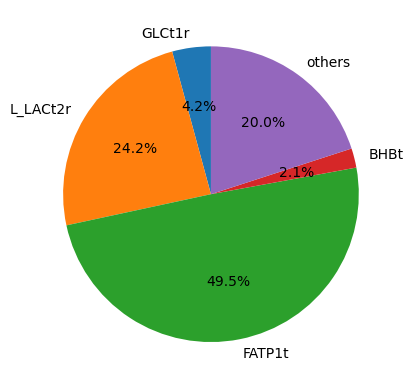

In [89]:
# Make a pi chart of the carbon contribution of the different metabolites
# Uptakes rates 
import pandas as pd

rows = ['GLCt1r',  'L_LACt2r','FATP1t', 'BHBt',]
carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'FATP1t': 16, 'BHBt': 4, })[rows]

uptake_flux = sol.fluxes[rows].abs() * carbons[rows]

# 25% others 
uptake_flux['others'] = uptake_flux.abs().sum() * (1/0.80 - 1)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.pie(uptake_flux, labels=uptake_flux.index, autopct='%1.1f%%', startangle=90)

plt.show()


In [90]:
# Function to integrate metabolite concentrations
import numpy as np 
from optlang.exceptions import SolverError

def set_concentration(model, metabolite_id, concentration, uncertainty=0.1, unit='mmol/L', std=None):
    if unit == 'mmol/L':
        concentration = concentration / 1000
        if not std is None:
            std = std/1000
    else:
        raise ValueError('Unit not supported')
    

    metabolite = model.log_concentration.get_by_id(metabolite_id)
    compartment = model.metabolites.get_by_id(metabolite_id).compartment
    c_min = reduced_model.compartments[compartment]['c_min']

    var = metabolite.variable

    if std is None:
        var.ub = np.log(concentration + concentration * uncertainty)
        lb = np.log(concentration - concentration * uncertainty) \
            if concentration - concentration * uncertainty > c_min else np.log(c_min)
        var.lb = np.log(concentration - concentration * uncertainty)
    else:
        var.ub = np.log(concentration + std)
        lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
        var.lb = lb


    # Test the constraint
    try:
        sol = model.optimize()
        if sol.status != 'optimal':
            raise ValueError(f'Constraining {metabolite_id} to {concentration} failed.')
    except:
        raise ValueError(f'Constraning {metabolite_id} to {concentration} failed.')
    

In [91]:
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)

2024-09-06 15:56:48,475 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 83/83 [00:02<00:00, 38.45it/s]


In [92]:
reduced_model.compartments['c']['c_min']

1e-11

In [93]:
# Integrate serum metabolomics 

# Glucose concentration in serum
glucose_concentration = 5.5 # mmol/L 
# Lactate concentration in serum
lactate_concentration = 0.75 # mmol/L
# Fatty-acid concentration in serum
fatty_acid_concentration = 0.5 # mmol/L
# Ketone concentration in serum 
ketone_concentration = 0.1 # mmol/L

# O2 concentration in serum 80 mmHG -> to mmol/L
T = 273.15 + 37
o2_concentration_artery = 1e3 * 80/ (62.36367*T)
o2_concentration_muscle = 1e3 * 30/ (62.36367*T)

# CO2 concentration in serum 40 mmHG -> to mmol/L
co2_concentration = 1e3 * 40/ (62.36367*T)

na1_concentration_serum = 140 # mmol/L
na1_concentration_muscle = 20 # mmol/L

set_concentration(reduced_model, 'glc_D_e', glucose_concentration)

set_concentration(reduced_model, 'lac_L_e', lactate_concentration)
set_concentration(reduced_model, 'lac_L_c', lactate_concentration*0.8, uncertainty=0.5)
set_concentration(reduced_model, 'lac_L_m', lactate_concentration*0.5, uncertainty=0.99)


set_concentration(reduced_model, 'hdca_e', fatty_acid_concentration)
set_concentration(reduced_model, 'bhb_e', fatty_acid_concentration)
set_concentration(reduced_model, 'o2_e', o2_concentration_artery, uncertainty=0.1)
set_concentration(reduced_model, 'o2_c', o2_concentration_muscle*0.75, uncertainty=0.1)
set_concentration(reduced_model, 'o2_m', o2_concentration_muscle*0.5, uncertainty=0.1)

set_concentration(reduced_model, 'co2_e', co2_concentration)

# Not in new model...
set_concentration(reduced_model, 'na1_e', na1_concentration_serum)
set_concentration(reduced_model, 'na1_c', na1_concentration_muscle)


# Set the concentration of the cytosol -> 10% of the serum concentration
set_concentration(reduced_model, 'hdca_c', fatty_acid_concentration*0.1)

reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442937,None
AKGDm,0.442937,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
CYOR_u10mi,2.560000,None
NADH2_u10mi,1.845071,None
CYOOm2i,1.280000,None
cyt_atp2adp,6.061355,None


In [94]:
# # Add a ratio constraint Fix the MCT vs MPC ratio
# sol = reduced_model.optimize()  
# carbohydrate_lac_eq_flux_in = (sol['EX_glc_D_e'] * 2 + sol['EX_lac_L_e']) * -1 

# TVA_ALL = []

# FVA_ALL = [] 

# fraction_mpc = np.linspace(0.1, 0.9, 100)
# for f in fraction_mpc:
#     mpc_flux = f * carbohydrate_lac_eq_flux_in
#     bounds = (mpc_flux - 1e-3, mpc_flux + 1e-3)
#     reduced_model.reactions.PYRt2m.bounds = bounds  
#     sol = reduced_model.optimize()

#     print(f"MPC: {sol['PYRt2m']/ (sol['PYRt2m'] + sol['L_LACtm']) } \
#             MCT1: {sol['L_LACtm']/ (sol['PYRt2m'] + sol['L_LACtm'])} ATP: {sol.objective_value}")
    
#     TVA = variability_analysis(reduced_model, kind=LogConcentration)
#     TVA['Fraction_MPC'] = f
#     TVA_ALL.append(TVA)

#     FVA = variability_analysis(reduced_model, kind='reactions')
#     FVA['Fraction_MPC'] = f
#     FVA_ALL.append(FVA)



# TVA_ALL = pd.concat(TVA_ALL)
# TVA_ALL.reset_index(inplace=True)

# FVA_ALL = pd.concat(FVA_ALL)
# FVA_ALL.reset_index(inplace=True)


In [95]:
# import seaborn as sns
# metabolites = ['LC_pyr_m', 'LC_pyr_c', 'LC_lac_L_c', 'LC_lac_L_m', ]

# TVA_MPC = TVA_ALL.melt(id_vars=['index', 'Fraction_MPC'], value_vars=['minimum', 'maximum'])

# # Scale the values to mmol/L
# TVA_MPC['value'] = np.exp(TVA_MPC['value']) 

# sns.lineplot(data=TVA_MPC[TVA_MPC['index'].isin(metabolites)], 
#              x='Fraction_MPC', y='value', 
#              style='variable',hue='index',alpha=0.9)

# plt.yscale('log')
# # legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Add a title
# plt.title('Sensitivity of metabolite concentrations to MCT/MPC ratio')
# plt.ylabel('Concentration (mol/L)')
# plt.xlabel('Fraction of MPC ($\\frac{v_{MPC}}{v_{MPC} + v_{MCT}}$)')

# plt.show()

In [96]:
reduced_model.reactions.G3PD1

Reaction identifier,G3PD1
Name,Glycerol-3-Phosphate Dehydrogenase _NAD
Memory address,0x07f7b6a2c6520
Stoichiometry,glyc3p_c + nad_c <=> dhap_c + 2.0 h_c + nadh_c Glycerol 3-Phosphate + Nicotinamide Adenine Dinucleotide <=> Dihydroxyacetone Phosphate + 2.0 Proton + Nicotinamide Adenine Dinucleotide - Reduced
GPR,2819.1
Lower bound,-200.0
Upper bound,200.0


In [97]:
#reduced_model.solver.problem.conflict.refine()
#reduced_model.solver.problem.conflict.write('bla.txt')

In [98]:
# Read the tissue metabolomics data
import pandas as pd
tissue_metabolomics = pd.read_csv('./../data/C57BL6_6hr_fasted.csv')

tissue_type = 'Soleus'

tissue_samples = tissue_metabolomics.Tissue == tissue_type
tissue_metabolomics[tissue_samples]



,Tissue,a-ketoglutarate,alanine,arginine,asparagine,aspartate,citrate,fumarate,glutamate,glutamine,...,methionine,phenylalanine,proline,pyruvate,serine,succinate,threonine,tryptophan,tyrosine,valine
48,Soleus,164.82,8830.95,166.09,125.35,343.31,506.18,41.44,4334.70,3264.68,...,32.66,58.63,86.84,375.54,261.30,74.22,197.54,15.66,43.59,171.44
49,Soleus,270.08,20673.02,135.75,175.04,1091.43,441.79,63.14,4171.56,2943.38,...,42.34,78.29,86.92,560.16,315.55,173.60,236.77,14.86,71.53,184.09
50,Soleus,221.14,18248.35,190.22,196.63,2462.46,390.77,93.81,2686.22,2526.05,...,65.75,70.51,124.80,717.46,374.81,183.29,302.36,17.03,115.98,187.89
51,Soleus,218.93,18785.52,180.17,183.07,1992.65,354.46,95.38,3141.48,2557.69,...,61.26,60.67,123.48,698.18,370.55,181.01,277.40,17.02,95.59,191.78


In [99]:
metabolite_mapping = [
    ('a-ketoglutarate', ('akg_m', 3.0)),
    ('a-ketoglutarate', ('akg_c', 3.0)),
    ('citrate', ('cit_m', 1.0)),
    ('fumarate', ('fum_m', 1.0)),
    #('lactate', ('lac_L_c', 5.0)),
    #('lactate', ('lac_L_m', 5.0)),
    ('malate', ('mal_L_m', 3.0)),
    ('malate', ('mal_L_c', 3.0)),
    ('pyruvate', ('pyr_m', 5.0)),
    ('pyruvate', ('pyr_c', 5.0)),
    ('succinate', ('succ_m', 1.0)),
    ('glutamate', ('glu_L_m', 3.0)),
    ('glutamate', ('glu_L_c', 3.0)),
    ('aspartate', ('asp_L_m', 5.0)),
    ('aspartate', ('asp_L_c', 3.0)),
]

metabolites_to_map = list(set(m[0] for m in metabolite_mapping))
data_extracted = tissue_metabolomics[tissue_samples][metabolites_to_map] * 1e-3
data_extracted

,pyruvate,glutamate,a-ketoglutarate,citrate,malate,succinate,aspartate,fumarate
48,0.37554,4.33470,0.16482,0.50618,0.21508,0.07422,0.34331,0.04144
49,0.56016,4.17156,0.27008,0.44179,0.33019,0.17360,1.09143,0.06314
50,0.71746,2.68622,0.22114,0.39077,0.50106,0.18329,2.46246,0.09381
51,0.69818,3.14148,0.21893,0.35446,0.52548,0.18101,1.99265,0.09538


In [100]:
# # Map the metabolomics data to the model
for metabolite_name, (metabolite_id, uncertainty_fac) in metabolite_mapping:
    concentration = data_extracted[metabolite_name].mean()
    uncertainty = data_extracted[metabolite_name].std()
    #print(f"{metabolite_name} concentration: {concentration} +/- {uncertainty*uncertainty_fac}")
    uncertainty = 1-2**-uncertainty_fac
    set_concentration(reduced_model, metabolite_id, concentration, uncertainty=uncertainty)
    


In [101]:
# Metabolomics from taras paper (we use soleus concentrtions)
set_concentration(reduced_model, 'g6p_c', 0.88, std=0.04*3)
set_concentration(reduced_model, 'f6p_c', 0.88*0.8, std=0.04*3)
set_concentration(reduced_model, 'fdp_c', 0.44, std=0.18)
reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442937,None
AKGDm,0.442937,None
AKGMALtm,0.118816,None
ASPGLUm,0.118816,None
...,...,...
CYOR_u10mi,2.560000,None
NADH2_u10mi,1.845071,None
CYOOm2i,1.280000,None
cyt_atp2adp,6.031651,None


In [102]:
# Carnitine concentration 3.600 um/kg ~ 3.6 mM
carnitine_concentration = 3.6 * 0.9
set_concentration(reduced_model, 'crn_c', carnitine_concentration)
set_concentration(reduced_model, 'crn_m', carnitine_concentration)


# pmt-carnitine in cytosol 100 uM range
set_concentration(reduced_model, 'pmtcrn_c', carnitine_concentration * 0.1 , 0.9)
set_concentration(reduced_model, 'pmtcrn_m', carnitine_concentration * 0.1 , 0.9)

# acyl-CoA in cytosol 100 uM range
set_concentration(reduced_model, 'pmtcoa_c', 100e-3 , 0.9)

sol = reduced_model.optimize()
print(sol.objective_value)

6.031651217391305


In [103]:
sol = reduced_model.optimize()
carbohydrate_lac_eq_flux_in = (sol['EX_glc_D_e'] * 2 + sol['EX_lac_L_e']) * -1 
lac_uptake = sol['EX_lac_L_e'] * -1

# We need to make additional flux assumptions to identify the a flux profile
reduced_model.reactions.LDH_L.bounds = (0, 100)
reduced_model.reactions.LDH_Lm.bounds = (-0.01, 0)

# Assume the direaction of all three shuttles
reduced_model.reactions.AKGMALtm.bounds = (0.02, 0.15)
reduced_model.reactions.G3PD1.bounds = (-0.15, -0.02)

# LDH-D (Fe2+) is not the dominant LDH in muscle 
reduced_model.reactions.L_LACDcm.bounds = (0, 0.1)

sol = reduced_model.optimize()


In [104]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2024-09-06 15:56:52,923 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 71/71 [00:00<00:00, 74.24it/s]


In [105]:
FVA.loc['LDH_Lm', :]

minimum   -0.01
maximum    0.00
Name: LDH_Lm, dtype: float64

In [106]:
# Remove the reactions that cannot carry flux
EPSILON = 1e-6  
reactions_to_remove = [r for r in reduced_model.reactions if FVA.loc[r.id, 'minimum'] >= -EPSILON and FVA.loc[r.id, 'maximum'] <= EPSILON ]
print(reactions_to_remove)
reduced_model.remove_reactions(reactions_to_remove)
reduced_model.repair()

metabolites_to_remove = [m for m in reduced_model.metabolites if len(m.reactions) == 0]
reduced_model.remove_metabolites(metabolites_to_remove)
reduced_model.repair()

sol = reduced_model.optimize()
print(sol.objective_value)

[<Reaction ACYP at 0x7f7b6a2c6190>]
6.0166512173913045


In [107]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

fasted_fluxes = FVA['mid']

2024-09-06 15:56:54,949 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 70/70 [00:00<00:00, 80.35it/s]


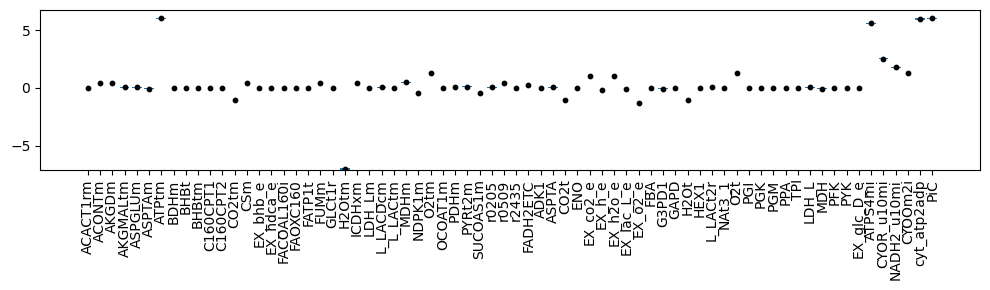

In [108]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

f = plt.figure(figsize=(10, 3))
plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)

# from cobra.flux_analysis.parsimonious import optimize_minimal_flux
# reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')
# sol = optimize_minimal_flux(reduced_model)
# plt.scatter(sol.fluxes.index, sol.fluxes, color='r', s=10)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [109]:
# Print bidreactional reactions from FVA
for r in reduced_model.reactions:
    if FVA.loc[r.id, 'minimum'] < -EPSILON and FVA.loc[r.id, 'maximum'] > EPSILON:
        print(r.id, r.reaction, FVA.loc[r.id, ['minimum', 'maximum']].values)


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'EX_bhb_e'),
  Text(1, 0, 'EX_hdca_e'),
  Text(2, 0, 'EX_co2_e'),
  Text(3, 0, 'EX_h_e'),
  Text(4, 0, 'EX_h2o_e'),
  Text(5, 0, 'EX_lac_L_e'),
  Text(6, 0, 'EX_o2_e'),
  Text(7, 0, 'EX_glc_D_e')])

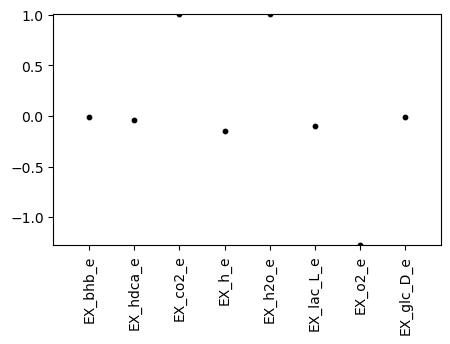

In [110]:
# Plot FVA of only exchage reactions
plt.figure(figsize=(5, 3))
#exchange_reactions = [r.id for r in reduced_model.metabolites.h_c.reactions]
exchange_reactions = [r.id for r in reduced_model.boundary]

FVA_exchange = FVA.loc[exchange_reactions]

FVA_exchange['range'] = FVA_exchange.maximum - FVA_exchange.minimum
FVA_exchange['mid'] = (FVA_exchange.maximum + FVA_exchange.minimum) / 2
plt.bar(FVA_exchange.index, FVA_exchange.range, bottom=FVA_exchange.minimum)
plt.scatter(FVA_exchange.index, FVA_exchange.mid, color='k', s=10)

plt.xticks(rotation=90)

In [111]:
# Print all reversible reaction formulas i.e. FVA (min < 0, max > 0)
for rxn in reduced_model.reactions:
    if FVA.loc[rxn.id].minimum < 0 and FVA.loc[rxn.id].maximum > 0:
        print(rxn.id, rxn.reaction)
        

In [112]:
np.exp(0.03/reduced_model.RT) - 1

0.0519736075490127

In [113]:
# Force minimal flux of 1e-4 and deltaG of -1e-4
EPSILON_DG = 0.03 # Eqivanet to about 5% displacement
EPSILON_FLUX = 1e-3
sol = reduced_model.optimize()

for rxn in reduced_model.reactions:
    if FVA.loc[rxn.id].maximum > 0:

        rxn.bounds = (EPSILON_FLUX, rxn.bounds[1])
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.ub = -EPSILON_DG
        except KeyError:
            pass
            
    elif FVA.loc[rxn.id].minimum < 0:
        rxn.bounds = (rxn.bounds[0], -EPSILON_FLUX)
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.lb = EPSILON_DG
        except KeyError:
            pass
    else:
        raise ValueError(f"Somthing is really from with{rxn.id}")

    try:
        sol = reduced_model.optimize()
        if sol.status != 'optimal':
            raise ValueError(f"Failed to constrain {rxn.id}")
    except SolverError:
        raise ValueError(f"Failed to constrain {rxn.id}")

2024-09-06 15:56:58,593 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 82/82 [00:00<00:00, 91.15it/s]


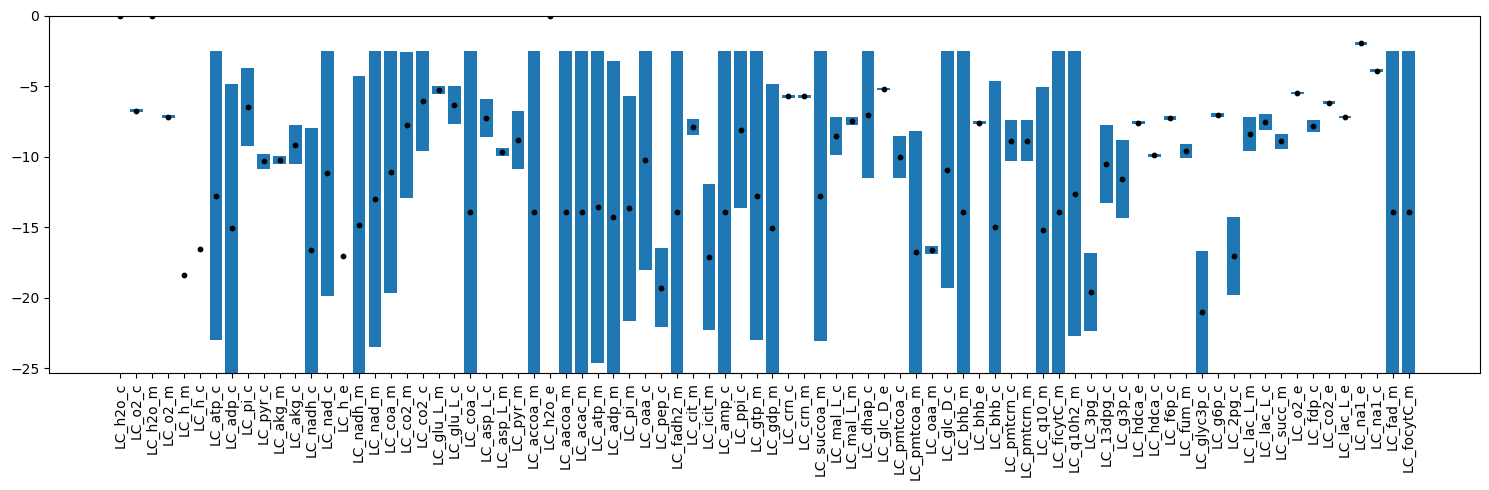

In [114]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Concentration of metabolites
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)


# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))
TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)
plt.scatter(TVA.index, TVA.mid, color='k', s=10)
plt.xticks(np.arange(len(TVA.index)), TVA.index, rotation=90)
plt.tight_layout()

plt.show()

In [115]:
from pytfa.analysis import  apply_reaction_variability,     \
                            apply_generic_variability,      \
                            apply_directionality

from pytfa.optim.variables import DeltaG,DeltaGstd,LogConcentration
# Fesiblitity analysis
solution = reduced_model.optimize()


# TVA of the model
thermo_vars = [DeltaG,DeltaGstd,LogConcentration]
TVA = variability_analysis(reduced_model, kind=thermo_vars)


# Strip model of integers variables
fixed_directionality_model = apply_directionality(reduced_model, solution)
tight_model = apply_reaction_variability(fixed_directionality_model, FVA)
tight_model = apply_generic_variability (tight_model  , TVA)

2024-09-06 15:57:01,051 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 60/60 [00:00<00:00, 86.73it/s]
2024-09-06 15:57:02,651 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 60/60 [00:00<00:00, 75.19it/s]
2024-09-06 15:57:04,070 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 82/82 [00:00<00:00, 89.86it/s]


In [116]:
from pytfa.optim import strip_from_integer_variables
from pytfa.analysis import sample

continuous_model = strip_from_integer_variables(tight_model)
continuous_model.repair()

2024-09-06 15:57:06,472 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


In [117]:
continuous_model.solver.configuration.tolerances.feasibility = 1e-9
continuous_model.solver.configuration.tolerances.optimality = 1e-9
continuous_model.solver.configuration.tolerances.integrality = 1e-9


In [118]:
continuous_model.delta_g.TPI.reaction.reaction

'dhap_c --> g3p_c'

In [119]:
# Gelta D constraints for glycolysis (Lehninger)
continuous_model.delta_g.FBA.variable.lb = -6 * 0.239006
continuous_model.delta_g.TPI.variable.lb = -0.5 * 0.239006 # Shu be very close to equilibrium
continuous_model.delta_g.PGM.variable.ub = 0.5 * 0.239006 # reverse annotated
continuous_model.delta_g.PGK.variable.ub = 0.5 * 0.239006 # reverse annotated
continuous_model.delta_g.GAPD.variable.lb = -2 * 0.239006
continuous_model.delta_g.ENO.variable.lb = -0.5 * 0.239006




In [120]:
continuous_model.reactions.PiC.reaction

'h_c + pi_c --> h_m + pi_m'

In [121]:
# ATP synthesis + ATP transport should be thermodynamically controlled -> low energy leads to hyper polarization
continuous_model.delta_g.ATPS4mi.variable.lb = -1.0 # kcal/mol
continuous_model.delta_g.PiC.variable.lb = -1.0 # kcal/mol
continuous_model.delta_g.ATPtm.variable.lb = -1.0 # kcal/mol

continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442937,None
AKGDm,0.442937,None
AKGMALtm,0.098816,None
ASPGLUm,0.098816,None
...,...,...
CYOR_u10mi,2.560000,None
NADH2_u10mi,1.825071,None
CYOOm2i,1.280000,None
cyt_atp2adp,6.016651,None


In [122]:
# Other considerations
# PDHm is thought to be displaced from equilibrium
continuous_model.delta_g.PDHm.variable.ub = -2 # kcal/mol

# ATP synthase should be close to equilibrium -> control ATP demand
continuous_model.delta_g.ATPS4mi.variable.lb = -1.0 # kcal/mol

# Displace the NADH2_u10mi a bit more from equilibrium
continuous_model.delta_g.NADH2_u10mi.variable.ub = -0.5 # kcal/mol
continuous_model.delta_g.NADH2_u10mi.variable.lb = -4.0 # kcal/mol

# Close to equilibrium
continuous_model.delta_g.FADH2ETC.variable.lb = -0.2 # kcal/mol

# Push BHBm and OCOAT1m towards equilibrium 
continuous_model.delta_g.BHBt.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.BHBtm.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.BDHm.variable.lb = -10.0 # kcal/mol
#continuous_model.delta_g.OCOAT1m.variable.lb = -1.0 # kcal/mol

# # Some constraint on the G3PD1 shuttle
# # NOTE-> needs to be displaced other withse this leads to coupeling lactate uptake to glucose uptake
# continuous_model.delta_g.G3PD1.variable.lb = 2.0 * 0.24 # kcal/mol
# continuous_model.delta_g.r0205.variable.ub = -2.0 * 0.24 # kcal/mol 

# Force the Asapartate/Malte shuttle to be clsoe ot equilibrium
continuous_model.delta_g.ASPTA.variable.lb = -1.0 * 0.24 # kcal/mol
continuous_model.delta_g.ASPTAm.variable.ub = 1.0 * 0.24 # kcal/mol
continuous_model.delta_g.MDHm.variable.lb = -1.0 * 0.24 # kcal/mol
continuous_model.delta_g.ASPGLUm.variable.lb = -1.0 * 0.24 # kcal/mol
continuous_model.delta_g.AKGMALtm.variable.lb = -1.0 * 0.24 # kcal

# This should be the control point since it senses cytosolic NADH
continuous_model.delta_g.MDH.variable.ub = 2.0 * 0.24 # kcal/mol
continuous_model.delta_g.MDH.variable.ub = 10.0 * 0.24 # kcal/mol

# Limit to a reasonable range
continuous_model.delta_g.ACACT1rm.variable.ub = 5.0 # kcal/mol

# Equilbrium of fat (mass action driven)
continuous_model.delta_g.FATP1t.variable.ub = 0.5 # kcal/mol


In [123]:
# Make some assumption on the most importat 

# NAD concentration
nad_concentration = 1.5 # mM
set_concentration(continuous_model, 'nad_c', nad_concentration, uncertainty=0.9)
set_concentration(continuous_model, 'nad_m', nad_concentration, uncertainty=0.9)

# Assumption of OAA 10 uM rangge
set_concentration(continuous_model, 'oaa_m', 1e-3, 0.99)
set_concentration(continuous_model, 'oaa_c', 10e-3, 0.9)

# FAD concentration
fad_concentration = 0.05 # mM

set_concentration(continuous_model, 'fad_m', fad_concentration, uncertainty=0.9)
#set_concentration(continuous_model, 'fadh2_m', fad_concentration, uncertainty=0.9)


# GDP concentration
gdp_concentration = 0.05 # mM
set_concentration(continuous_model, 'gtp_m', gdp_concentration, uncertainty=0.5)

# ATP concentration 10 uM range
set_concentration(continuous_model, 'atp_c', 10e-3, uncertainty=0.5)

# Mitochondiral ATP concentration 
set_concentration(continuous_model, 'atp_m', 10e-3, uncertainty=0.5)

# Ubiqionone 40 uM range  https://www.nature.com/articles/pr2015124
set_concentration(continuous_model, 'q10h2_m' , 40e-3, uncertainty=0.5)
set_concentration(continuous_model, 'q10_m' , 4e-3, uncertainty=0.99)


# Ferrocyto-chrome 1uM range
set_concentration(continuous_model, 'ficytC_m', 1e-3, uncertainty=0.5)

# Free CoA low 10 uM range
set_concentration(continuous_model, 'coa_m' , 10e-3, uncertainty=0.99)
set_concentration(continuous_model, 'coa_c' , 20e-3, uncertainty=0.5)

# Alcyl-CoA mit 1 nM range
set_concentration(continuous_model, 'pmtcoa_m', 1e-6, uncertainty=0.5)
# Alcyl-CoA cyt 1 uM range
set_concentration(continuous_model, 'pmtcoa_c', 7e-3, uncertainty=0.5)

# Phosphate concentration 5 mM 
# https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2012.00463/full
set_concentration(continuous_model, 'pi_c', 5, 0.5)
#set_concentration(continuous_model, 'pi_m', 0.9, 0.5)



# Intra cellular glucose should be lowish
set_concentration(continuous_model, 'glc_D_c', glucose_concentration * 1e-3 , 0.5)

# Mitochondiral acac low 
set_concentration(continuous_model, 'acac_m', 1e-3, 0.5)


# succoa_m 10 uM range
set_concentration(continuous_model, 'succoa_m', 500e-3, 0.99)

# mitochondiral co2 abour 2 fold hiher than extracellular + gradient
set_concentration(continuous_model, 'co2_m', 2 * co2_concentration, 0.1)
set_concentration(continuous_model, 'co2_c', 1.5 * co2_concentration, 0.1)

# Diphsophate 
set_concentration(continuous_model, 'ppi_c', 2, 0.9)

# AMP 70 nM
set_concentration(continuous_model, 'amp_c', 70e-6, 0.9)

# This is only in the extended model
#set_concentration(continuous_model, 'glyc3p_c', 0.1e-3, 0.99)


In [124]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)


2024-09-06 15:57:07,655 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 82/82 [00:00<00:00, 699.76it/s]


In [125]:
# Sample the concnetrations and fluxes in the continuous_model
sampling = sample(continuous_model, 200, processes=20, seed=0,  method='optgp')

2024-09-06 15:57:08,064 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-06 15:57:09,655 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-06 15:57:11,480 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2024-09-06 15:57:11,484 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm_reverse_3c90a
2024-09-06 15:57:11,490 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm
2024-09-06 15:57:11,493 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2024-09-06 15:57:11,499 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm
2024-09-06 15:57:11,504 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb


2024-09-06 15:57:12,563 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 82/82 [00:00<00:00, 649.51it/s]


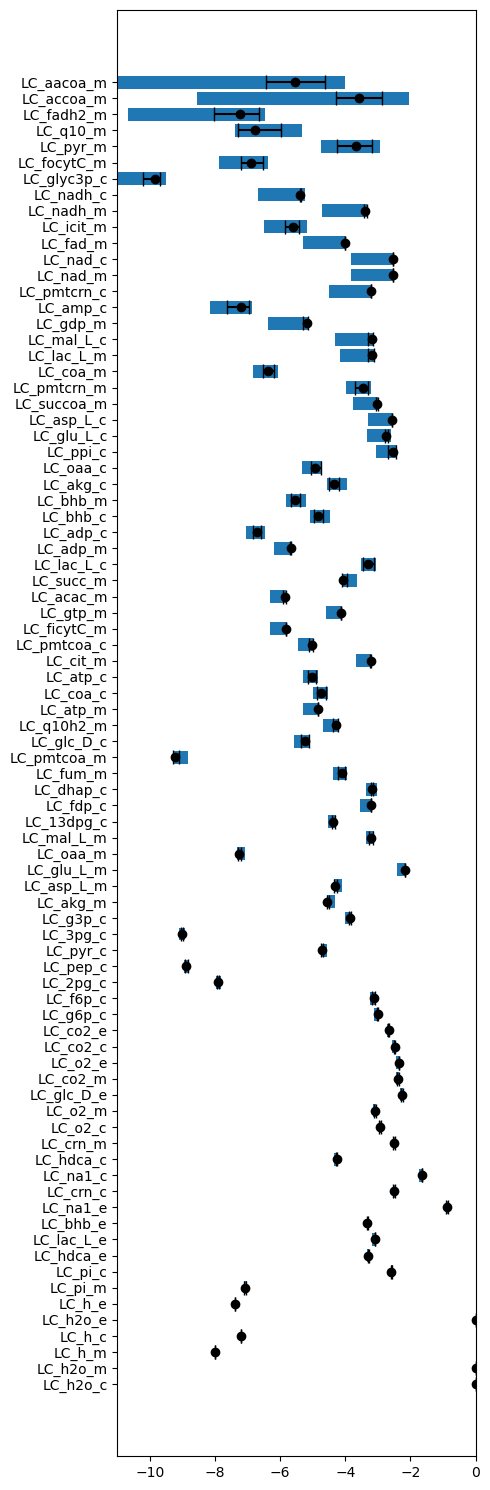

In [126]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(5, 15))

# Convert from ln to log10
TVA['minimum'] = np.log10(np.exp(TVA.minimum))
TVA['maximum'] = np.log10(np.exp(TVA.maximum))
sampling_log10 = np.log10(np.exp(sampling))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# TVA sort by range
TVA = TVA.sort_values('range', ascending=True)

LC_MEDIAN = sampling_log10.median()[TVA.index]
LC_UQ = sampling_log10.quantile(0.95)[TVA.index]
LC_LQ = sampling_log10.quantile(0.05)[TVA.index]


plt.barh(TVA.index, TVA.range, left=TVA.minimum)
plt.errorbar( LC_MEDIAN, TVA.index, xerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)
# Align the xticks with the metabolites names
plt.yticks(np.arange(0,len(TVA.index)),  TVA.index,)
plt.tight_layout()
plt.show()



2024-09-06 15:57:13,638 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 60/60 [00:00<00:00, 934.60it/s]


(-50.0, 20.0)

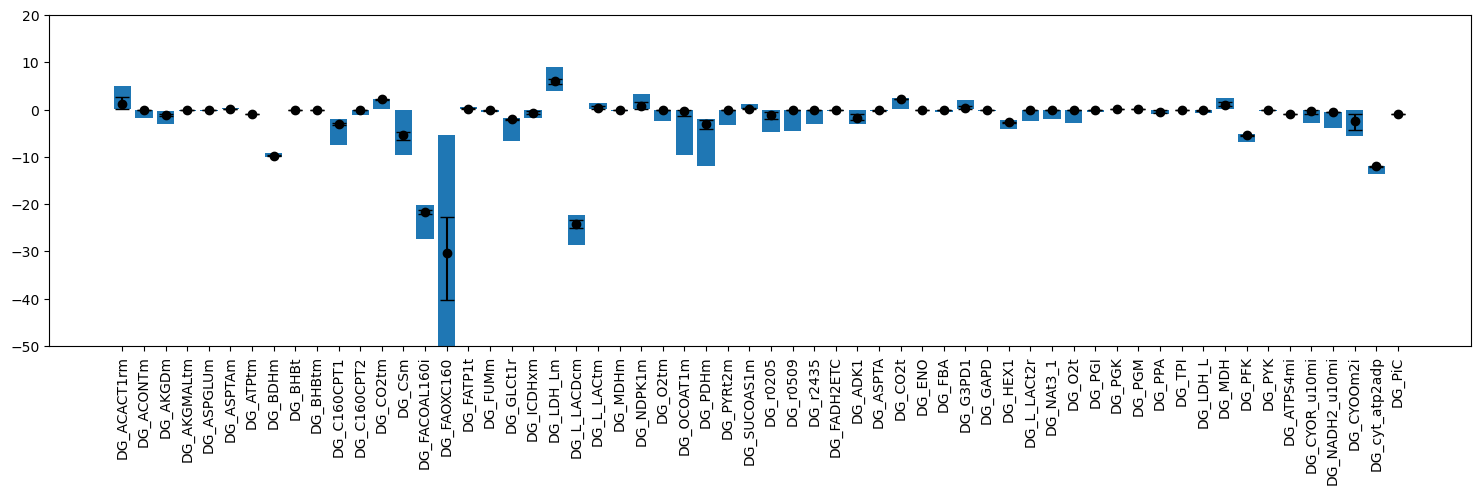

In [127]:
from pytfa.optim.variables import DeltaG
# PLot the TVA of the reaction deltaG
TVA = variability_analysis(continuous_model, kind=DeltaG)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)

LC_MEDIAN = sampling.median()[TVA.index]
LC_UQ = sampling.quantile(0.95)[TVA.index]
LC_LQ = sampling.quantile(0.05)[TVA.index]

plt.errorbar(TVA.index, LC_MEDIAN, yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)

plt.xticks(np.arange(0,len(TVA.index)),  TVA.index, rotation=90)
plt.tight_layout()


plt.ylim(-50, 20)

In [128]:

# 
aspartate_malate_shuttle = ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']

#TVA.loc[['DG_G3PD1','DG_TPI','DG_r0205'],:]/0.239006

TVA.loc[[ 'DG_'+r for r in aspartate_malate_shuttle],:]/0.239006

,minimum,maximum,range,mid
DG_MDH,0.783794,10.041589,9.257795,5.412692
DG_ASPTA,-1.004159,-0.125520,0.878639,-0.564839
DG_ASPTAm,0.125520,1.004159,0.878639,0.564839
DG_MDHm,-1.004159,-0.125520,0.878639,-0.564839
DG_ASPGLUm,-1.004159,-0.125520,0.878639,-0.564839
DG_AKGMALtm,-1.004159,-0.125520,0.878639,-0.564839


In [129]:
sampling

,ACACT1rm,ACACT1rm_reverse_3c90a,ACONTm,ACONTm_reverse_8079b,AKGDm,AKGDm_reverse_ec8eb,AKGMALtm,AKGMALtm_reverse_8c3a3,ASPGLUm,ASPGLUm_reverse_b29bf,...,DG_CYOR_u10mi,DGo_CYOR_u10mi,DG_NADH2_u10mi,DGo_NADH2_u10mi,DG_CYOOm2i,DGo_CYOOm2i,DG_cyt_atp2adp,DGo_cyt_atp2adp,DG_PiC,DGo_PiC
0,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.099761,0.0,0.099761,0.0,...,-0.054007,5.796125,-0.5,-4.212042,-2.093963,-12.754884,-12.006430,-6.214697,-0.999022,5.142734
1,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.099772,0.0,0.099772,0.0,...,-0.719668,5.811128,-0.5,-4.873146,-2.047538,-12.755739,-12.004468,-6.214697,-0.998998,5.142734
2,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.098553,0.0,0.098553,0.0,...,-0.695334,5.808143,-0.5,-4.772053,-1.967417,-12.763116,-12.038491,-6.214697,-0.981082,5.142734
3,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.096193,0.0,0.096193,0.0,...,-0.201308,5.787770,-0.5,-4.353811,-2.092551,-12.719781,-12.047745,-6.214697,-0.972901,5.142734
4,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.095555,0.0,0.095555,0.0,...,-0.510314,5.787806,-0.5,-5.140659,-2.622274,-12.294894,-12.050959,-6.214697,-0.974597,5.142734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.092999,0.0,0.092999,0.0,...,-0.581059,6.000412,-0.5,-5.747420,-3.514079,-12.708694,-12.016250,-6.214697,-0.999276,5.142734
196,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.092750,0.0,0.092750,0.0,...,-0.587053,5.994346,-0.5,-5.686589,-3.325425,-12.659058,-12.019505,-6.214697,-0.998825,5.142734
197,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.090744,0.0,0.090744,0.0,...,-0.622516,6.008666,-0.5,-5.707831,-3.224790,-12.671259,-12.025833,-6.214697,-0.997007,5.142734
198,0.0,0.006636,0.442937,0.0,0.442937,0.0,0.091907,0.0,0.091907,0.0,...,-0.987366,6.057849,-0.5,-5.890289,-2.832875,-12.786028,-12.018509,-6.214697,-0.996446,5.142734


/home/daniel/miniconda3/envs/skimpy-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


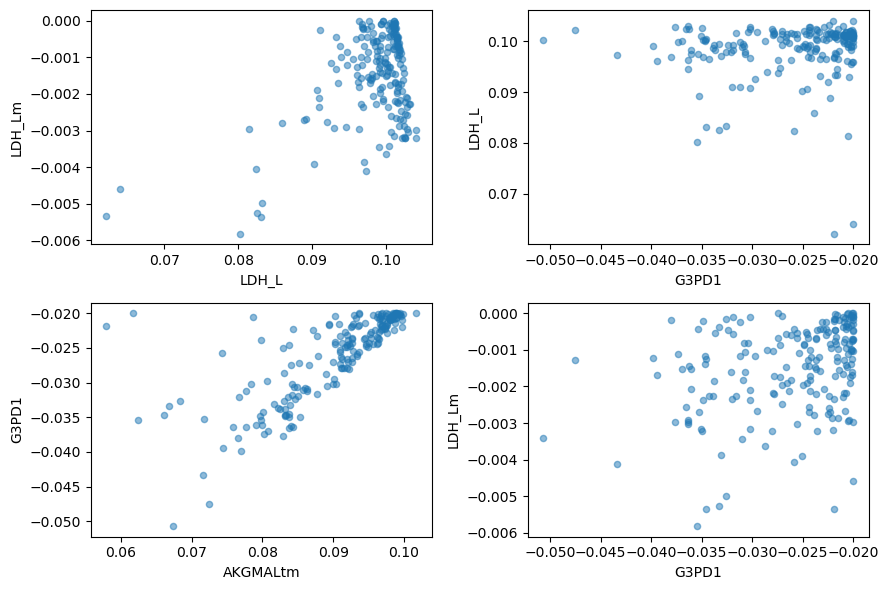

In [130]:
f, ax = plt.subplots(2,2, figsize=(9,6))

fluxes = sampling.iloc[:, 0:2*len(continuous_model.reactions):2] - sampling.iloc[:, 1:2*len(continuous_model.reactions)+1:2].values


fluxes.plot.scatter('LDH_L', 'LDH_Lm', alpha=0.5, ax =ax[0,0])
fluxes.plot.scatter('G3PD1', 'LDH_L', alpha=0.5, ax =ax[0,1])
fluxes.plot.scatter('AKGMALtm','G3PD1',  alpha=0.5, ax =ax[1,0])
fluxes.plot.scatter('G3PD1', 'LDH_Lm', alpha=0.5, ax =ax[1,1])

# for a in ax.flatten():
#     a.set_xlim(0,0.2)
#     a.set_ylim(0,0.2)

FVA.loc['PYRt2m']
plt.tight_layout()

In [131]:
sampling['G3PD1_reverse_84a31']

0      0.021014
1      0.022033
2      0.022376
3      0.024390
4      0.024418
         ...   
195    0.020253
196    0.021502
197    0.021612
198    0.024919
199    0.025523
Name: G3PD1_reverse_84a31, Length: 200, dtype: float64

In [132]:
# Print all reaction with a deltaG_std  > +/- 10 kcal/mol
for rxn in continuous_model.reactions:
    if rxn.thermo['deltaGR'] > 5 and not rxn in continuous_model.boundary:
        print(rxn.id, rxn.reaction, rxn.thermo)

ACACT1rm 2.0 accoa_m <-- aacoa_m + coa_m {'isTrans': False, 'computed': True, 'deltaGR': 7.0560000000002105, 'deltaGRerr': 1.087366929789572}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}
FBA fdp_c --> dhap_c + g3p_c {'isTrans': False, 'computed': True, 'deltaGR': 5.604831372302954, 'deltaGRerr': 1.231339855604455}
PYK adp_c + h_c + pep_c --> atp_c + pyr_c {'isTrans': False, 'computed': True, 'deltaGR': 5.609472160844774, 'deltaGRerr': 0.654304974763298}
CYOR_u10mi 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m {'isTrans': True, 'computed': True, 'deltaGR': 9.322982768466911, 'deltaGrxn': -11.643612983011053, 'deltaGRerr': 2.9916129428788074}
NADH2_u10mi 6.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m {'isTrans': True, 'computed': True, 'deltaGR': 27.49278536786197, 'deltaGrxn': -3.957108259354982, 'deltaGRerr': 3.07450548869245}


In [133]:
# Print all reactions that use amp_c
for rxn in continuous_model.reactions:
    if 'amp_c' in [m.id for m in rxn.metabolites]:
        print(rxn.id, rxn.reaction, rxn.thermo)

FACOAL160i atp_c + coa_c + hdca_c --> amp_c + h_c + pmtcoa_c + ppi_c {'isTrans': False, 'computed': True, 'deltaGR': -21.838258329698704, 'deltaGRerr': 1.2316793413871974}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}


In [134]:
# Write the samples to a csv file
sampling.to_csv( redgem_file_name.replace('.json','_tfa_sampling.csv'), index=False)


In [135]:
# Save the continuous model
from pytfa.io.json import save_json_model
save_json_model(continuous_model, redgem_file_name.replace('.json', '_continuous.json'))

In [136]:
# This as an attempt not really makes sense
# dissipation = sum([ r.variable * reduced_model.reactions.get_by_id(r.id).reverse_variable 
#                - r.variable * reduced_model.reactions.get_by_id(r.id).forward_variable 
#                for r in reduced_model.delta_g])

# # Objective function
# reduced_model.objective = reduced_model.problem.Objective(dissipation, direction='min')

# reduced_model.solver.problem.parameters.optimalitytarget.set(3)

# reduced_model.optimize()

# Integrate fed state fluxes into the continous models

In [137]:

# Relax the bounds but keep the directionality of dGs and fluxes
for reaction in continuous_model.reactions:
    if reaction.upper_bound > 0:
        reaction.bounds = (EPSILON_FLUX, 100)
    elif reaction.lower_bound < 0:
        reaction.bounds = (-100, -EPSILON_FLUX)

In [138]:
# Flux constraints for the core model 
RER = 0.9
fraction_of_whole_body_o2 = 0.8
total_carbon_contribution_modeled = 0.80

o2_uptake = 2.0 * fraction_of_whole_body_o2 * total_carbon_contribution_modeled
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
# continuous_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
continuous_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)

#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.23 / 6 / total_carbon_contribution_modeled
lactate_direct_contribution = 0.22 / 3 / total_carbon_contribution_modeled
bhb_direct_contribution = 0.008 / 4 / total_carbon_contribution_modeled

continuous_model.reactions.EX_glc_D_e.bounds = (-co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)
continuous_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
continuous_model.reactions.EX_bhb_e.bounds = (-co2_production * bhb_direct_contribution, -co2_production * bhb_direct_contribution)
sol = continuous_model.optimize()

2024-09-06 15:57:15,489 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 70/70 [00:00<00:00, 493.83it/s]


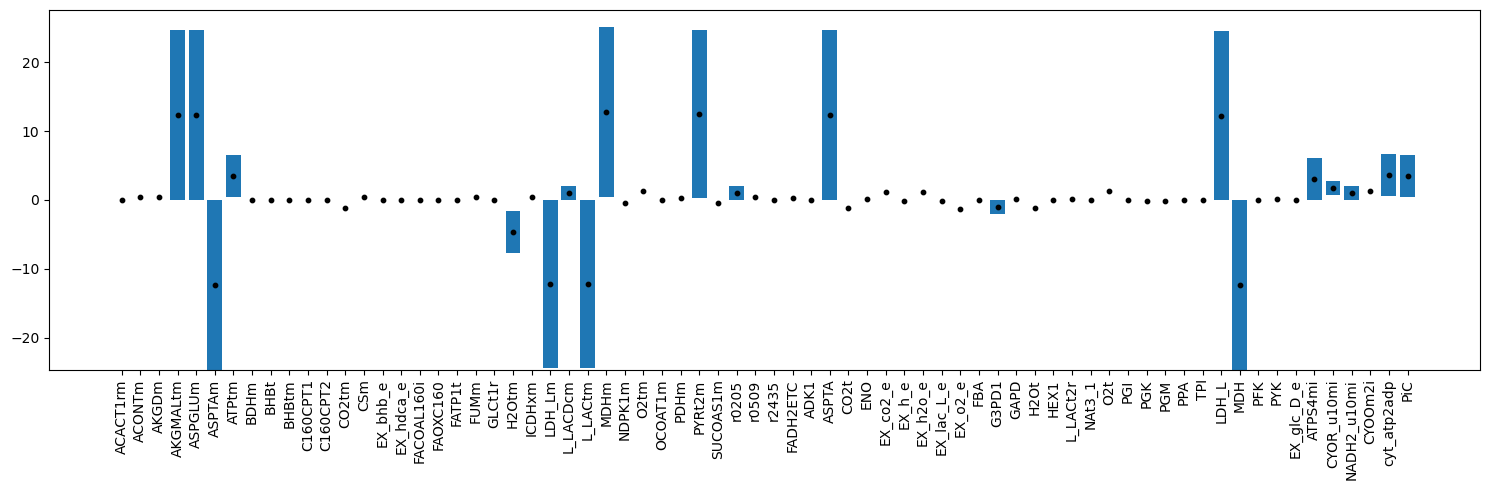

In [139]:
# Run and plot the flux variablity analysis
FVA = variability_analysis(continuous_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)
plt.xticks(np.arange(len(FVA.index)), FVA.index, rotation=90)

plt.tight_layout()

fed_fluxes = FVA['mid']

In [140]:
# Save the two mid flux profiles to a file
import pandas as pd 
df = pd.DataFrame([fasted_fluxes, fed_fluxes], index=['fasted','fed']).T
df.to_csv(redgem_file_name.replace('.json','_char_flux_profiles.csv'))

Text(0.5, 1.0, 'RER fasted: 0.78')

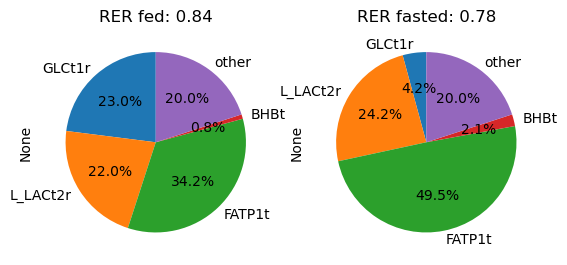

In [141]:
# Compute the mean carbon flux from fed fed state predition 

mean_carbon_flux_fed = df.loc[:,'fed'].loc[rows].abs() * carbons
mean_carbon_flux_fasted = df.loc[:,'fasted'].loc[rows].abs() * carbons


# Add a column that accounts for 25% of the total flux and label it as 'other'
mean_carbon_flux_fed['other'] = mean_carbon_flux_fed.sum() * (1/0.80 - 1)
mean_carbon_flux_fasted['other'] = mean_carbon_flux_fasted.sum() * (1/0.80 - 1)

# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots(1,2)
mean_carbon_flux_fed.plot.pie(ax=ax[0], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
mean_carbon_flux_fasted.plot.pie(ax=ax[1], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)

rer_fed = - df.loc['EX_co2_e','fed'] / df.loc['EX_o2_e','fed']
rer_fasted = - df.loc['EX_co2_e','fasted'] / df.loc['EX_o2_e','fasted']

# Note that this RER is based on 80% oxygen consumptuion
ax[0].set_title(f"RER fed: {rer_fed:.2f}")
ax[1].set_title(f"RER fasted: {rer_fasted:.2f}")

In [142]:
rer_fed = - df.loc['EX_co2_e','fed'] / df.loc['EX_o2_e','fed']

#### Sanity Checks on electron transports delta Gs

In [143]:
# Compute the redox potential of the NADH/NAD+ couple in the model
# NAD+ + H+ + 2e- ->  NADH
dG = continuous_model.metabolites.nad_c.thermo['deltaGf_std'] + continuous_model.metabolites.h_c.thermo['deltaGf_std'] - continuous_model.metabolites.nadh_c.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

-0.3165590506296296

In [144]:
# Compute the redox potential of the NADH/NAD+ couple in the model
# FAD + 2H+ + 2e- -> FADH2 (currently FAD is deprotonated so missing an H+)
dG = continuous_model.metabolites.fad_m.thermo['deltaGf_std'] + 3*continuous_model.metabolites.h_m.thermo['deltaGf_std'] - continuous_model.metabolites.fadh2_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

-0.19426133595895678

In [145]:
# Compute the redox potential of the Cytochrome couple in the model
# cyt c (Fe3+) + e- -> cyt c (Fe2+)
dG = continuous_model.metabolites.ficytC_m.thermo['deltaGf_std']  - continuous_model.metabolites.focytC_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

0.12499999999999999

In [146]:
# Compute the redox potential of the Q10/Q10H2 couple in the model
# Q10 + 2H+ + 2e- -> Q10H2 
dG = continuous_model.metabolites.q10_m.thermo['deltaGf_std'] + 2*continuous_model.metabolites.h_m.thermo['deltaGf_std'] - continuous_model.metabolites.q10h2_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

0.05724081463439945